# condynsate.Simulator

## Setting up the Simulation Environment

Import necessary `condynsate` modules

In [1]:
from condynsate import Simulator as conSim
from condynsate import __assets__ as assets

Create a instance of `condynsate.simulator` that does not use the keyboard or the animator but does use the visualizer at a frame rate of 24 fps

In [2]:
simulator = conSim(keyboard = False,
                   visualization = True,
                   animation = False)

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7033/static/


Load the pendulum into the simulator. Set `fixed = true` so that the base link of the pendulum is fixed in space. Set `update_vis = true` so that its position updates are reflected in the visualizer. Additionally, set the base pitch to 180 degrees and the yaw to 90 degrees so the pendulum is oriented downward and swings in the YZ visual plane, respectively.

In [3]:
pendulum = simulator.load_urdf(urdf_path = assets['pendulum'],
                               fixed = True,
                               update_vis = True,
                               yaw = 1.571, # All angle arguments are in radians
                               pitch = 3.142) # All angle arguments are in radians

Set the `"chassis_to_arm"` joint friction to some small value. The `"chassis_to_arm"` joint is the rotational joint about which the pendulum swings

In [4]:
simulator.set_joint_damping(urdf_obj = pendulum,
                            joint_name = 'chassis_to_arm',
                            damping = 0.05)

Set the initial angle of the pendulum. We denote that this is an initial condition with the `initial_cond = True` flag and we make the change instantaneously by using the `physics = False` flag.

In [5]:
initial_angle = 0.1745
simulator.set_joint_position(urdf_obj = pendulum,
                             joint_name = 'chassis_to_arm',
                             position = initial_angle, # For a rotational joint, this value is in radians
                             initial_cond = True,
                             physics = False)

## Setting up Data Collection

For fun, we will compare the dynamics of our nonlinear simulation to the small-angle linear approximation of pendulum dynamics. To do so, we define the small-angle pendulum dynamics approximations.

In [6]:
# Use a numerical integrator and the linear approximation of pendulum dynamics to get an estimated trajectory
import numpy as np
linear_angle = lambda t : initial_angle * np.cos(np.sqrt(9.81/1.0) * np.array(t))
linear_angle_vel = lambda t : -np.sqrt(9.81/1.0) * initial_angle * np.sin(np.sqrt(9.81/1.0) * np.array(t))

Create an empty dictionary to collect simulation data

In [7]:
data = {'angle' : [],
        'angle_vel' : [],
        'time' : [],}

## Running the Simulation

Run the simulation in a loop. Begin by resetting the simulation using `condynsate.Simulator.reset`, then create a loop. The loop terminates when the flag `condynsate.Simulator.is_done` flips to True. In each time step of the simulation loop we do three things:
1. Take a simulation time step.
2. Extract and store the state of the `"chassis_to_arm"` joint. if a successful simulation step is taken. (Successful simulation steps are indicated by `condynsate.Simulator.step` having a `ret_code` greater than `0`.
3. Reset the data dictionary if the simulation was reset during `condynsate.Simulator.step`. A simulation reset is indicated by `condynsate.Simulator.step` having a `ret_code` equal to `0`.

By setting the `real_time = True` flag and `max_time = 5.0` in `condynsate.Simulator.step`, we tell the simulation to attempt to run in real time for 5 seconds. 

In [8]:
# Reset before running a simulation loop
simulator.reset()

# Get the initial joint state at time t = 0.
state = simulator.get_joint_state(urdf_obj = pendulum,
                                  joint_name = 'chassis_to_arm')
data['time'].append(simulator.time)
data['angle'].append(state['position'])
data['angle_vel'].append(state['velocity'])

# Create the main simulation loop
while(not simulator.is_done):    
    # Take a single physics step of condynsate.Simulator.dt seconds. This will
    # automatically update the physics and the visualizer, and attempts
    # to run in real time.
    ret_code = simulator.step(real_time = True,
                              max_time = 5.0)

    # Add the simulation data at the current time if a simulation step is taken
    if ret_code > 0:
        state = simulator.get_joint_state(urdf_obj = pendulum,
                                          joint_name = 'chassis_to_arm')
        data['time'].append(simulator.time)
        data['angle'].append(state['position'])
        data['angle_vel'].append(state['velocity'])
    
    # Handle resetting the data collection if the simulation is reset.
    if ret_code == 0:
        data = {'angle' : [],
                'angle_vel' : [],
                'time' : [],}

## Post-Processing

Here we format and plot the data we collected during the simulation using the `matplotlib` package.

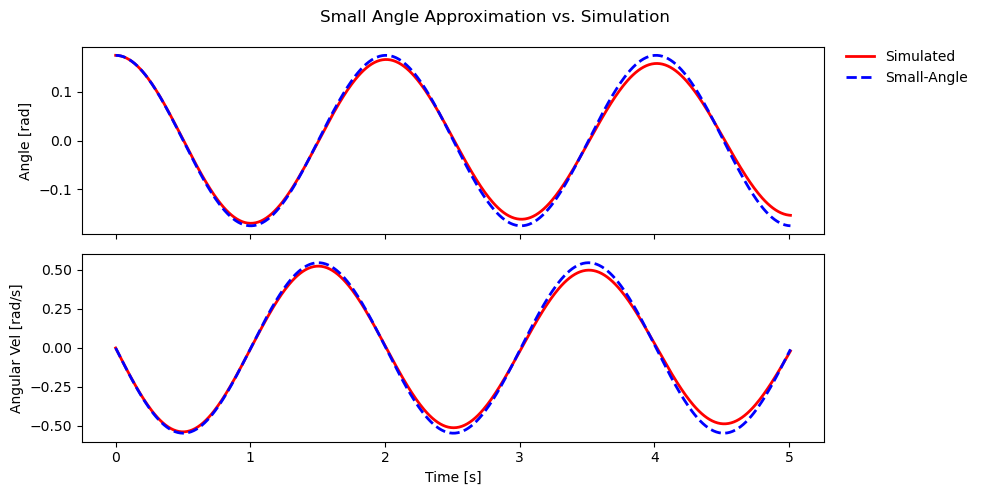

In [9]:
# Plot simulation data
import matplotlib.pyplot as plt
%matplotlib inline

# Create the plot
fig, axes = plt.subplots(ncols=1, nrows=2, sharex=True, figsize=(10,5))

# Plot the angles
axes[0].plot(data['time'], data['angle'], c='r', lw=2, label='Simulated')
axes[0].plot(data['time'], linear_angle(data['time']), c='b', lw=2, ls="--", label='Small-Angle')
axes[0].set_ylabel("Angle [rad]")
axes[0].legend(bbox_to_anchor=(1.21, 1.05), frameon=False)

# Plot the angluar velocities
axes[1].plot(data['time'], data['angle_vel'], c='r', lw=2, label='Simulated')
axes[1].plot(data['time'], linear_angle_vel(data['time']), c='b', lw=2, ls="--", label='Small-Angle')
axes[1].set_xlabel("Time [s]")
axes[1].set_ylabel("Angular Vel [rad/s]")
fig.suptitle("Small Angle Approximation vs. Simulation")
plt.tight_layout()

As expected, because the initial angle was small (~10 degrees) the period of the nonlinear simulation and linear approximation are close; however, due to the joint damping the amplitude of the simulation decreases with time. This behavior is not captured by the small-angle approximation. 